### **Importing the requited Libraries**

In [1]:
import pandas as pd
import numpy as np
import warnings
import joblib
import sys
import pickle
import seaborn as sns
from keras.layers import Dense
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score,\
    recall_score, precision_score, confusion_matrix

### **Loading raw data, split  it, then process it using load_split_preprocess helper function**

In [2]:
'''
sys.path.append('..') 
from load_split_preprocess import load_and_preprocess_data
X_train, X_test, y_train, y_test, preprocessor = load_and_preprocess_data("../data/processed/heart_cleaned_data.csv")

'''

'\nsys.path.append(\'..\') \nfrom load_split_preprocess import load_and_preprocess_data\nX_train, X_test, y_train, y_test, preprocessor = load_and_preprocess_data("../data/processed/heart_cleaned_data.csv")\n\n'

### **Or use**

In [3]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Load data
heart_data = pd.read_csv("../data/processed/heart_cleaned_data.csv")

# Define features and target
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target_variable = 'HeartDisease'

# Splitting the data
X = heart_data[numerical_features + categorical_features]
y = heart_data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

# Preprocessing for numerical and categorical features
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### **Helper function that plot best model evaluation**

In [4]:
import sys
sys.path.append('../src')  

from plot_model_evaluation import plot_model_evaluation  # Import the function

### **1 - Random Forest**

Best Parameters Found:
{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 100}
Train Accuracy: 0.8638
Test Accuracy: 0.9239
Mean Cross-Validation Accuracy: 0.8515
Training Accuracy: 0.8638
Precision: 0.9048
Recall: 0.9596
AUC Score_test: 0.9755
AUC Score_train: 0.9755


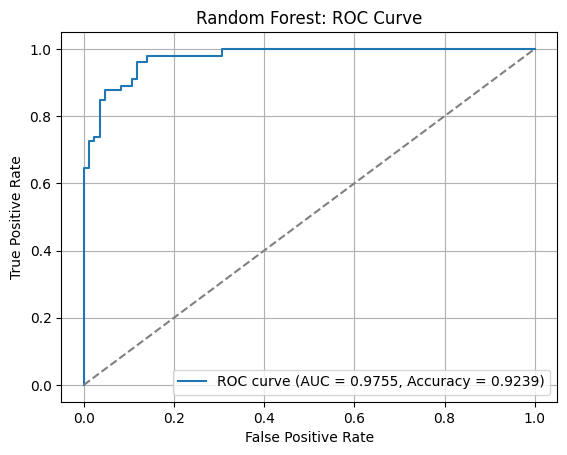

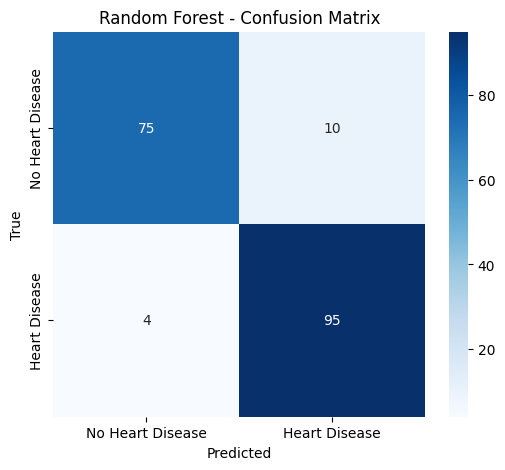

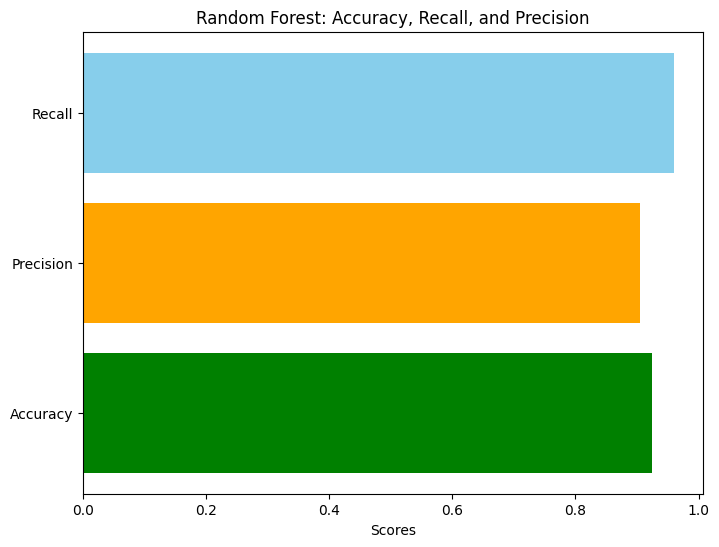

Best model saved as 'best_rf_model.pkl'


In [5]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=67)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)])

# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [3],  # Maximum depth of trees
    'classifier__min_samples_split': [20],  # Minimum samples required to split a node
    'classifier__min_samples_leaf': [20],    # Minimum samples required at leaf node
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_rf_model = grid_search.best_estimator_


y_pred = best_rf_model.predict(X_test)

# Test accuracy on the best model
train_accuracy = accuracy_score(y_train, best_rf_model.predict(X_train))
test_accuracy = accuracy_score(y_test, best_rf_model.predict(X_test))
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Perform cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


# Calculate AUC for the best model
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score_test: {auc_score:.4f}")

y_pred_prob_train = best_rf_model.predict_proba(X_train)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_prob_train)
print(f"AUC Score_train: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot confusion matrix, AUC_ROC, (accuracy, recall, and precision) for the best model
plot_model_evaluation(
    model_name="Random Forest",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle
with open('../models/best_rf_model.pkl', 'wb') as file:
    joblib.dump(best_rf_model, file)
    print("Best model saved as 'best_rf_model.pkl'")
    
  

In [19]:
joblib.load('../models/best_rf_model.pkl')  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=20,
                                        min_samples_split=20,
                                        random_state=67))])

### **2 - Logistic Regression**

Best Parameters Found:
{'classifier__C': 0.19144819761699575, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Mean Cross-Validation Accuracy: 0.8570
Train Accuracy: 0.8638
Test Accuracy: 0.9076
Precision: 0.9271
Recall: 0.8990
AUC Score_test: 0.9697
AUC Score_train: 0.9697


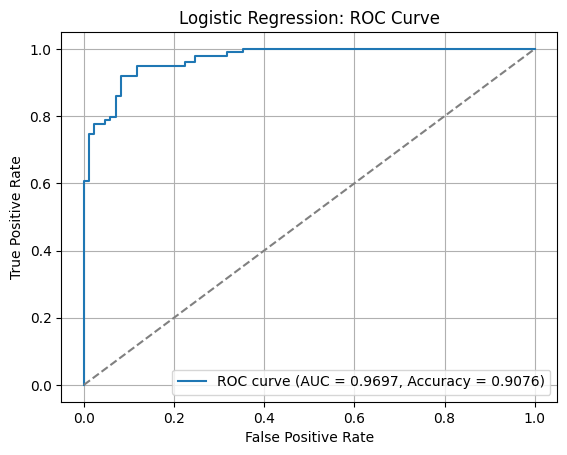

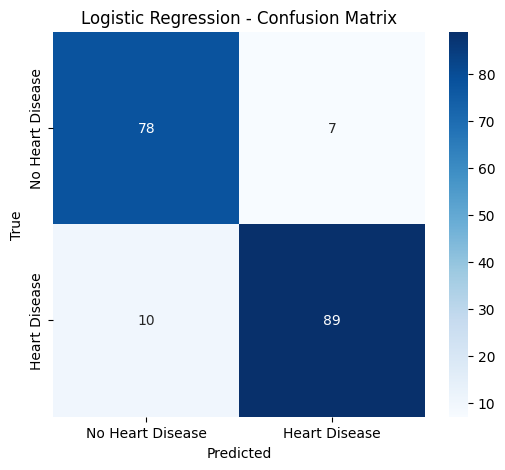

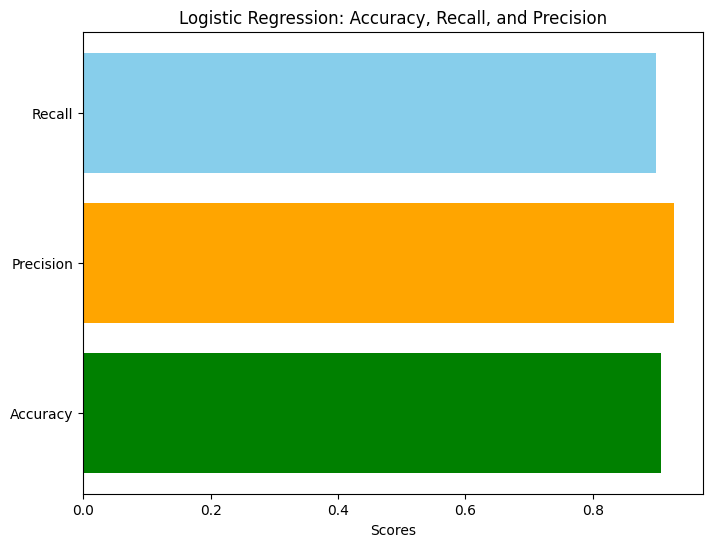

Best model saved as 'best_logreg_model.pkl'


In [7]:

# Create a Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", logreg)])

# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': np.logspace(-4, 4, 40),  # Regularization strength (inverse of C)
    'classifier__penalty': ['l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for optimization
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_logreg_model = grid_search.best_estimator_

y_pred = best_logreg_model.predict(X_test)


# Perform cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_logreg_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

train_accuracy = accuracy_score(y_train, best_logreg_model.predict(X_train))
test_accuracy = accuracy_score(y_test, best_logreg_model.predict(X_test))
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_logreg_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score_test: {auc_score:.4f}")

y_pred_prob_train = best_logreg_model.predict_proba(X_train)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_prob_train)
print(f"AUC Score_train: {auc_score:.4f}")

# Plot confusion matrix, AUC_ROC, (accuracy, recall, and precision) for the best model
plot_model_evaluation(
    model_name="Logistic Regression",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle  
with open('../models/best_logreg_model.pkl', 'wb') as file:
    joblib.dump(best_logreg_model, file)
    print("Best model saved as 'best_logreg_model.pkl'")
    
  

In [8]:
joblib.load('../models/best_logreg_model.pkl')  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier',
                 LogisticRegression(C=0.19144819761699575, max_iter=1000,
                                    solver='liblinear'))])

### **3 - KNN**

Best Parameters Found:
{'classifier__n_neighbors': 20}
Mean Cross-Validation Accuracy: 0.8638
Train Accuracy: 0.8638
Test Accuracy: 0.9076
Precision: 0.9362
Recall: 0.8889
AUC Score_test: 0.9700
AUC Score_train: 0.9700


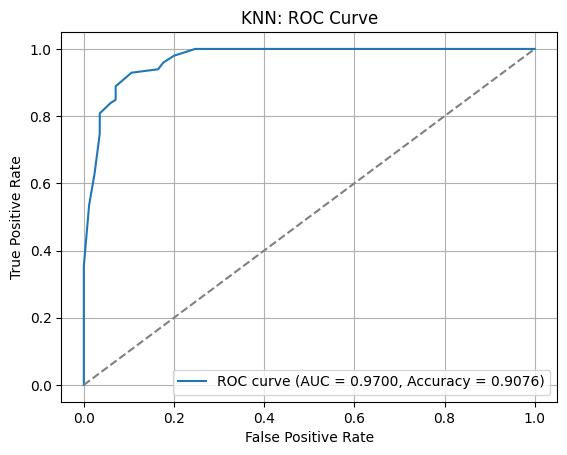

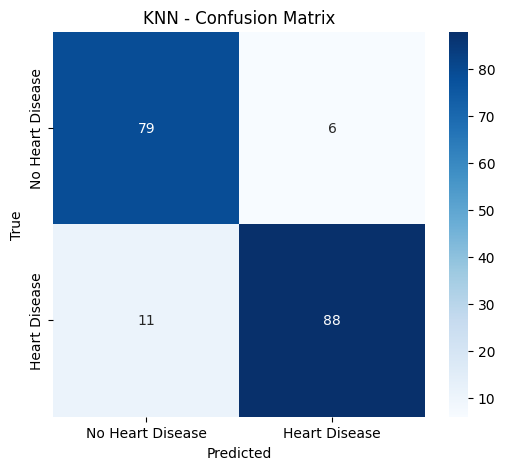

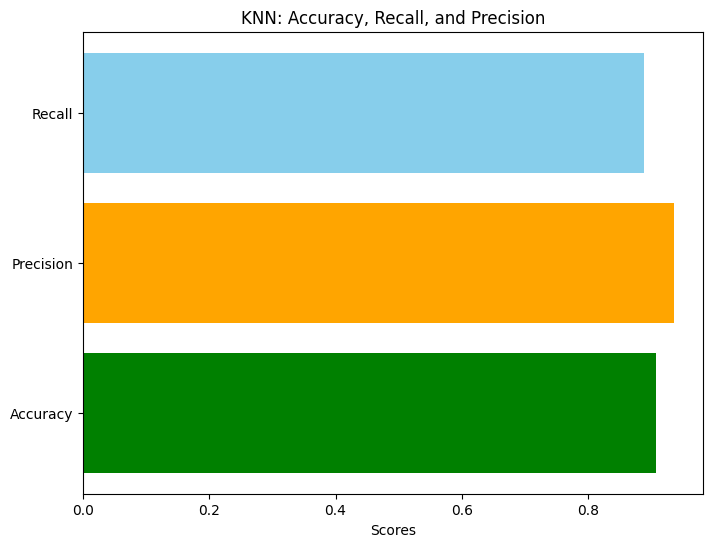

Best model saved as 'best_knn_model.pkl'


In [9]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", knn)])

# Define parameter grid for KNN classifier
param_grid = {
    'classifier__n_neighbors': np.arange(2, 50, 2),  # Varying n_neighbors
   
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_knn_model = grid_search.best_estimator_

# Test predictions
y_pred = best_knn_model.predict(X_test)

# Perform cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_knn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

# Test accuracy on the best model
train_accuracy = accuracy_score(y_train, best_knn_model.predict(X_train))
test_accuracy = accuracy_score(y_test, best_knn_model.predict(X_test))
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


# Calculate AUC for the best model
y_pred_prob = best_knn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score_test: {auc_score:.4f}")

y_pred_prob_train = best_knn_model.predict_proba(X_train)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_prob_train)
print(f"AUC Score_train: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plot_model_evaluation(
    model_name="KNN",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle
with open('../models/best_knn_model.pkl', 'wb') as file:
    joblib.dump(best_knn_model, file)
    print("Best model saved as 'best_knn_model.pkl'")
    

In [20]:
joblib.load('../models/best_knn_model.pkl')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=20))])

### **4 - NEURAL NETWORK**

Best Parameters Found:
{'classifier__batch_size': 32, 'classifier__epochs': 100}
Some variables were not restored.
Mean Cross-Validation Accuracy: 0.8447
Train Accuracy: 0.8488
Test Accuracy: 0.8859
Precision: 0.8750
Recall: 0.9192
AUC Score_test: 0.9626
AUC Score_train: 0.9626


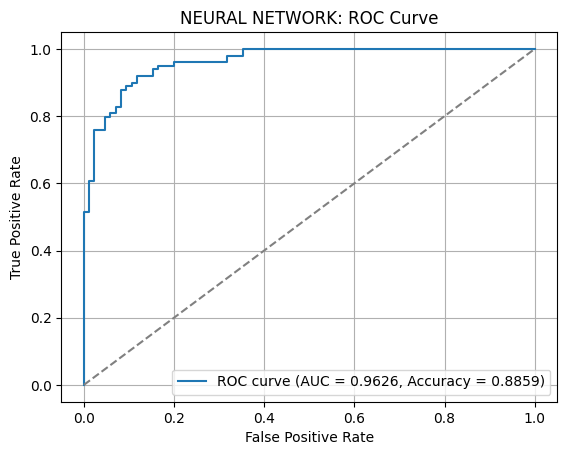

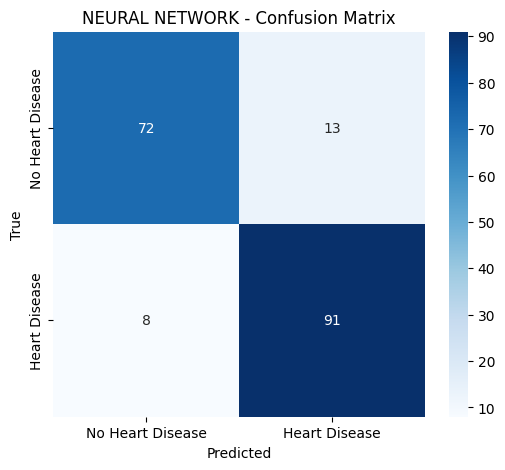

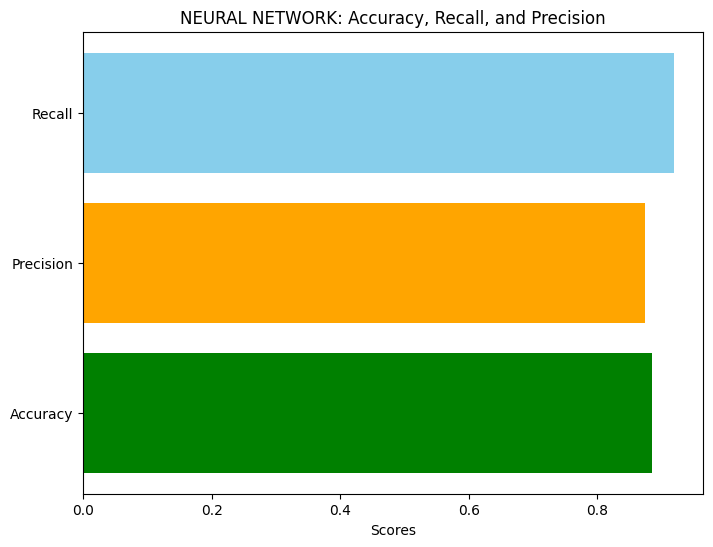

Best model saved as 'best_nn_model.pkl'


In [17]:
import warnings
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages (shows only ERRORs)

# Additional logging configuration
import logging
tf.get_logger().setLevel(logging.ERROR)


# To get the correct number of input features after one-hot encoding
X_train_transformed = preprocessor.fit_transform(X_train)
input_dim = X_train_transformed.shape[1]  # Number of features after preprocessing

# Function to create the Sequential model
def create_nn_model(hidden_layer_sizes=(64, 128)):
    model = Sequential()
    # Add input layer (with number of features as input_dim)
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # First hidden layer
    for units in hidden_layer_sizes:
        model.add(Dense(units, activation='relu'))  # Additional hidden layers
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the model weights from the epoch with the best value
)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='../models/best_nn_model_checkpoint',  # File path to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Only save the best model based on validation loss
    verbose=0,  #  verbose = 1 Print messages when the model is saved
    save_weights_only=False  # Save the entire model (including architecture, optimizer, and weights)
)

# Create a KerasClassifier wrapper for the neural network with EarlyStopping and ModelCheckpoint
nn_classifier = KerasClassifier(
    build_fn=create_nn_model, 
    epochs=200, 
    batch_size=32, 
    verbose=0, 
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stopping, checkpoint]  # Add both callbacks
)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", nn_classifier)])

# Define parameter grid for Neural Network
param_grid = {
    'classifier__epochs': [50, 100, 200],  # Number of epochs for training
    'classifier__batch_size': [32],  # Batch sizes
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_nn_model = grid_search.best_estimator_

# Extract the Keras model from the pipeline
keras_model = best_nn_model.named_steps["classifier"].model_


if keras_model is None:
    raise ValueError("The Keras model could not be extracted. Ensure the classifier is properly fitted.")

# Create a TensorFlow Checkpoint
checkpoint = tf.train.Checkpoint(model=keras_model)

# Define the path to the checkpoint directory
checkpoint_path = '../models/best_nn_model_checkpoint'

# Restore the checkpoint
status = checkpoint.restore(checkpoint_path)

# Check if all variables are restored
try:
    status.assert_consumed()
    print("All variables restored successfully.")
except AssertionError:
    print("Some variables were not restored.")



# Predictions
y_pred = best_nn_model.predict(X_test)

# Perform cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_nn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

# Test accuracy on the best model
train_accuracy = accuracy_score(y_train, best_nn_model.predict(X_train))
test_accuracy = accuracy_score(y_test, best_nn_model.predict(X_test))
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_nn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score_test: {auc_score:.4f}")

y_pred_prob_train = best_nn_model.predict_proba(X_train)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_prob_train)
print(f"AUC Score_train: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot confusion matrix, AUC_ROC, (accuracy, recall, and precision) for the best model
plot_model_evaluation(
    model_name="NEURAL NETWORK",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle
with open('../models/best_nn_model.pkl', 'wb') as file:
    joblib.dump(best_nn_model, file)
    print("Best model saved as 'best_nn_model.pkl'")


In [21]:
joblib.load('../models/best_nn_model.pkl')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier',
                 KerasClassifier(batch_size=32, build_fn=<function create_nn_model at 0x0000028AF46E0940>, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x0000028AEDEBC430>, <keras.src.callbacks.ModelCheckpoint object at 0x0000028AE9FFEEE0>], epochs=100, validation_split=0.2, verbose=0))])

### **Comparison: selecting the best model among the four best models**

Best Model: Random Forest
Metrics: {'accuracy': 0.9239130434782609, 'precision': 0.9047619047619048, 'recall': 0.9595959595959596, 'auc_score': 0.9755199049316696, 'confusion_matrix': array([[75, 10],
       [ 4, 95]], dtype=int64)}


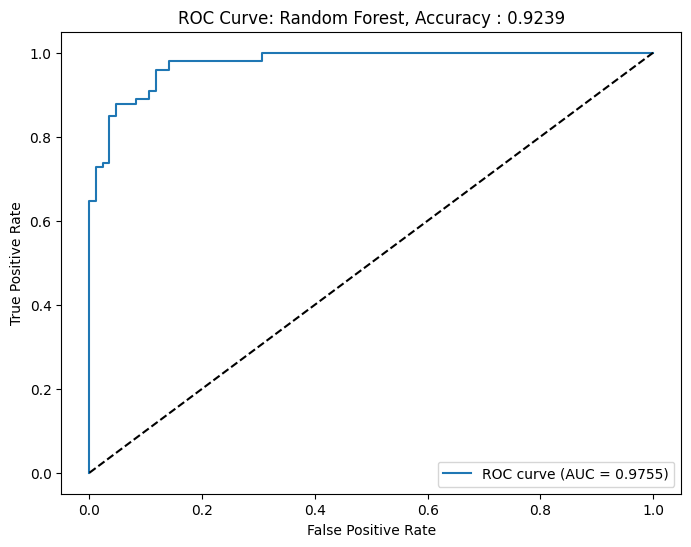

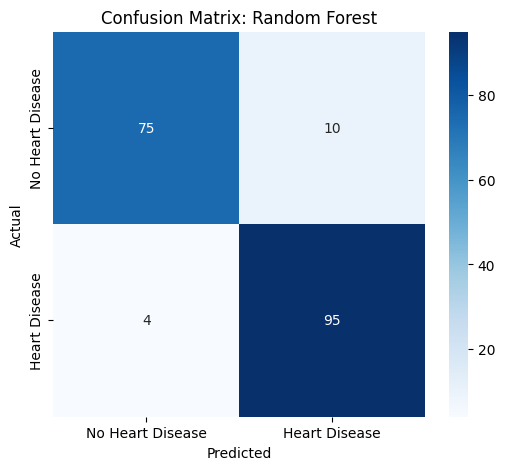

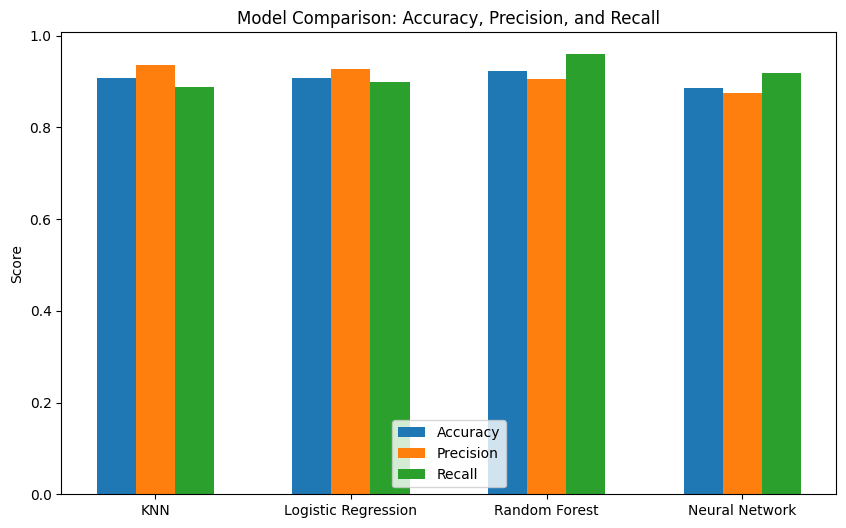

Best among the model saved as 'THE_BEST_AMONG_ALL_THE_MODELS.pkl'


In [22]:


# Function to load models from .pkl files
def load_model(filepath):
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
    return model

# Load the models
models = {
    "KNN": joblib.load("../models/best_knn_model.pkl"),
    "Logistic Regression": joblib.load("../models/best_logreg_model.pkl"),
    "Random Forest": joblib.load("../models/best_rf_model.pkl"),
    "Neural Network": joblib.load("../models/best_nn_model.pkl")
}

# Evaluate each model
model_metrics = {}
for model_name, model in models.items():
    # Predict and evaluate metrics
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

    model_metrics[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc_score": auc_score,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

# Determine the best model based on accuracy
best_model_name = max(model_metrics, key=lambda name: model_metrics[name]['accuracy'])
best_model = models[best_model_name]
best_metrics = model_metrics[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Metrics: {best_metrics}")

# Plot AUC for the best model
if best_metrics['auc_score'] is not None:
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {best_metrics['auc_score']:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
    plt.title(f"ROC Curve: {best_model_name}, Accuracy : {best_metrics['accuracy']:.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.savefig("../reports/THE_BEST_AMONG_ALL_THE_MODELS-ROC Curve.png")
    plt.show()

# Plot confusion matrix for the best model
cm = best_metrics['confusion_matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../reports/THE_BEST_AMONG_ALL_THE_MODELS-Confusion Matrix.png")
plt.show()

# Plot metrics for all models
metric_names = ['accuracy', 'precision', 'recall']
metrics_values = {metric: [model_metrics[model][metric] for model in models] for metric in metric_names}

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
bar_width = 0.2

for i, metric in enumerate(metric_names):
    plt.bar(x + i * bar_width, metrics_values[metric], bar_width, label=metric.capitalize())

plt.xticks(x + bar_width, models.keys())
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, Precision, and Recall")
plt.legend()
plt.savefig("../reports/Models Comparison-Accuracy, Precision, and Recall.png")
plt.show()

# Save the best model using pickle
with open('../models/best_model.pkl', 'wb') as file:
    joblib.dump(best_model, file)
    print("Best among the model saved as 'THE_BEST_AMONG_ALL_THE_MODELS.pkl'")

In [24]:
joblib.load('../models/best_model.pkl')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=20,
                                        min_samples_split=20,
                                        random_state=67))])